In [1]:
import subprocess as sp
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns  # for aesthetic

import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import numpy as np
import tempfile
import h5py as h5
import glob
import os
%matplotlib inline

sns.set_style('ticks')

/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [61]:
def rejection_sampling(command, seed=0):
    # Call sampler with subprocess
    proc = sp.run(command, stdout=sp.PIPE)
    # Read output as a facet list 
    facet_list = []
    for line in proc.stdout.decode().split("\n")[1:-1]:
        if line.find("#") == 0:
            yield facet_list
            facet_list = []
        else:
            facet_list.append([int(x) for x in line.strip().split()])
    yield facet_list
    
def prepare_scm_initial_condition(binmat, **kwargs):
    
    facets = sc.binarytomaxsimplex(binmat, rDup=True, **kwargs)
    with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as f: 
        fname = f.name
        for facet in facets:
            fstr = str(facet)
            fstr = fstr.replace('(', '')
            fstr = fstr.replace(')', '')
            fstr = fstr.replace(',', '')
            f.write(fstr+'\n')
    return fname

def prepare_scm_command(facet_file, nsamps):
    
    command = ['/home/brad/bin/mcmc_sampler', facet_file, '-t', str(nsamps)]
    return command

def extract_population_tensor(binned_data_file, stim, shuffle=False, clusters=None):
    print('Extracting Population Activity Tensor...')
    with h5.File(binned_data_file, 'r') as bdf:
        binned_clusters = np.array(bdf[stim]['clusters'])
        poptens = np.array(bdf[stim]['pop_tens'])
        print('Stim: {}, Clusters:{}'.format(stim, str(clusters)))
        try:
            if clusters is not None:
                poptens = poptens[np.in1d(binned_clusters, clusters), :, :]
                print("Selecting Clusters: poptens:" + str(np.shape(poptens)))
            (ncell, nwin, ntrial) = np.shape(poptens)
        except (ValueError, IndexError):
            print('Population Tensor Error')
            return []
        if shuffle:
            poptens = tp2.build_shuffled_data_tensor(poptens, 1)
            poptens = poptens[:, :, :, 0]
        if  nwin == 0:
            return []
    return poptens
            
def compute_trial_final_bettis(poptens, thresh, trial):
    popmat = poptens[:, :, trial]
    nclus = num_cells(poptens)
    popmat_binary = sc.binnedtobinary(popmat, thresh)
    bettis = tp2.calc_bettis(popmat, np.arange(nclus), '/home/brad/betti_pfile.txt', thresh)
    final_bettis = bettis[-1][1]
    return final_bettis

def compute_betti_curves(poptens, thresh, trial):
    popmat = poptens[:, :, trial]
    nclus = num_cells(poptens)
    bettis = tp2.calc_bettis(popmat, np.arange(nclus), '/home/brad/betti_pfile.txt', thresh)
    max_betti = max([len(x[1]) for x in bettis])
    betticurves = np.zeros((len(bettis), max_betti+1))
    betticurves[:, 0] = [x[0] for x in bettis]
    for bett in range(max_betti):
        betticurves[:, bett+1] = [x[1][bett] for x in bettis]
    return betticurves

def num_trials(poptens):
    (ncells, nwin, ntrials) = np.shape(poptens)
    return ntrials

def num_win(poptens):
    (ncells, nwin, ntrials) = np.shape(poptens)
    return nwin

def num_cells(poptens):
    (ncells, nwin, ntrials) = np.shape(poptens)
    return ncells
      
def calc_scm_betti_distribution(poptens, thresh, trial, nsamples):
    popmat = poptens[:, :, trial]
    popmat_bin = sc.binnedtobinary(popmat, thresh)
    fname = prepare_scm_initial_condition(popmat_bin)
    cmd = prepare_scm_command(fname, nsamples)
    samples = rejection_sampling(cmd)
    sample_bettis = []
    for sample in tqdm.tqdm(samples):
        bettis=[]
        cgs = [[1, x] for x in sample]
        tp2.build_perseus_input(cgs, '/home/brad/betti_pfile.txt')
        betti_file = tp2.run_perseus('/home/brad/betti_pfile.txt')
        try:
            with open(betti_file, 'r') as bf:
                for bf_line in bf:
                    if len(bf_line) < 2:
                        continue
                    betti_data = bf_line.split()
                    filtration_time = int(betti_data[0])
                    betti_numbers = list(map(int, betti_data[1:]))
                    bettis.append(np.array(betti_numbers))
        except:
            bettis.append([-1, [-1]])
        sample_bettis.append(bettis)
    return np.array(sample_bettis)

In [6]:
from importlib import reload
reload(tp2.events)
reload(tp2.core)
reload(tp2)

<module 'neuraltda.topology2' from '/home/brad/code/NeuralTDA/neuraltda/topology2.py'>

In [7]:
winsize = 10.0
segment_info = [0, 0]
pover = 0.5
block_path = '/home/brad/krista/B1083/P03S03/'
# Bin and compute SCG
bfdict = tp2.dag_bin(block_path, winsize, segment_info, cluster_group=['Good', 'MUA'], dt_overlap=pover*winsize, comment='fulltrial')
binned_data_file = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]


--- Logging error ---
Traceback (most recent call last):
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/logging/__init__.py", line 994, in emit
    stream.write(msg)
AttributeError: 'int' object has no attribute 'write'
Call stack:
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-pac

Data Not already binned


In [44]:
import tqdm
thresh = 13.0
nsamples = 30
stim_dict = {}
stim_shuffled_dict = {}
stim_scm_dict = {}
stim_betticurve_dict = {}
stim_shuffled_betticurve_dict = {}
with h5.File(binned_data_file, 'r') as bdf:
    stims = bdf.keys()
    for stim in stims:
        print(stim)
        stim_poptens = extract_population_tensor(binned_data_file, stim)
        stim_poptens_shuffled = extract_population_tensor(binned_data_file, stim, shuffle=True)
        ntrials = num_trials(stim_poptens)
        stim_dat = []
        stim_shuffled_dat= []
        stim_scm_dat= []
        stim_betticurve_dat= []
        stim_shuffled_betticurve_dat= []
        for trial in tqdm.tqdm(range(ntrials)):
            
            #stim_bettis = compute_trial_final_bettis(stim_poptens, thresh, trial)
            
            #stim_shuffled_bettis = compute_trial_final_bettis(stim_poptens_shuffled, thresh, trial)
            
            scm_bettis = calc_scm_betti_distribution(stim_poptens, thresh, trial, nsamples)
        
            stim_betticurves = compute_betti_curves(stim_poptens, thresh, trial)
            stim_shuffled_betticurves = compute_betti_curves(stim_poptens_shuffled, thresh, trial)
        
            #stim_dat.append(stim_bettis)
            #stim_shuffled_dat.append(stim_shuffled_bettis)
            stim_scm_dat.append(scm_bettis)
            stim_betticurve_dat.append(stim_betticurves)
            stim_shuffled_betticurve_dat.append(stim_shuffled_betticurves)
        stim_dict[stim] = stim_dat
        stim_shuffled_dict[stim] = stim_shuffled_dat
        stim_scm_dict[stim] = stim_scm_dat
        stim_betticurve_dict[stim] = stim_betticurve_dat
        stim_shuffled_betticurve_dict[stim] = stim_shuffled_betticurve_dat


  0%|          | 0/20 [00:00<?, ?it/s]

I_40k
Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None



  0%|          | 0/20 [00:00<?, ?it/s]

J_40k
Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None


  0%|          | 0/20 [00:00<?, ?it/s]

K_40k
Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None


  0%|          | 0/20 [00:00<?, ?it/s]

L_40k
Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None


  0%|          | 0/20 [00:00<?, ?it/s]

M_40k
Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None


  0%|          | 0/20 [00:00<?, ?it/s]

N_40k
Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None


  0%|          | 0/20 [00:00<?, ?it/s]

O_40k
Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None


  0%|          | 0/20 [00:00<?, ?it/s]

P_40k
Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None


100%|██████████| 20/20 [51:21<00:00, 170.00s/it]


In [45]:
import pickle
with open('scm_control_save2.pkl', 'wb') as f:
    pickle.dump([stim_dict, stim_shuffled_dict, stim_scm_dict, stim_betticurve_dict, stim_shuffled_betticurve_dict], f)

In [147]:
def plot_scm_distribution(scm_bettis, trial, bettinum, ax=None, **kwargs):
    
    scm_trial_bettis = scm_bettis[trial]
    bettivals = []
    try:
        for x in scm_trial_bettis:
            try:
                bettivals.append(x[0][bettinum])
            except IndexError:
                bettivals.append(0)
    except IndexError:
        bettivals = [x[bettinum] for x in scm_trial_bettis]
    ax.hist(bettivals, 20, normed=1, **kwargs)

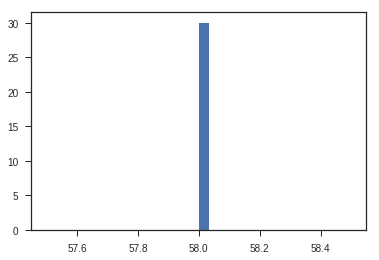

In [78]:
plot_scm_distribution(stim_scm_dict['I_40k'], 0, 1)

In [146]:
[scm_bettis][0][0][0][4]

IndexError: index 4 is out of bounds for axis 0 with size 3

In [39]:
stim_betticurve_dict['I_40k'][-1][-1]

array([  1.08800000e+03,   1.00000000e+00,   4.70000000e+01,
         1.98000000e+02,   0.00000000e+00])

In [132]:
# average over all trials
import tqdm
thresh = 13.0
nsamples = 200
stim_dict = {}
stim_shuffled_dict = {}
stim_scm_dict = {}
stim_betticurve_dict = {}
stim_shuffled_betticurve_dict = {}
with h5.File(binned_data_file, 'r') as bdf:
    stims = bdf.keys()
    for stim in tqdm.tqdm(stims):
        print(stim)
        trial=0
        stim_poptens = extract_population_tensor(binned_data_file, stim)
        stim_poptens_shuffled = extract_population_tensor(binned_data_file, stim, shuffle=True)
        ntrials = num_trials(stim_poptens)
        stim_dat = []
        stim_shuffled_dat= []
        stim_scm_dat= []
        stim_betticurve_dat= []
        stim_shuffled_betticurve_dat= []
        stim_trialavg_poptens = np.mean(stim_poptens, axis=2)[:, :, np.newaxis]
        stim_trialavg_poptens_shuffled = np.mean(stim_poptens_shuffled, axis=2)[:, :, np.newaxis]
            
        #stim_bettis = compute_trial_final_bettis(stim_poptens, thresh, trial)
            
        #stim_shuffled_bettis = compute_trial_final_bettis(stim_poptens_shuffled, thresh, trial)
            
        scm_bettis = calc_scm_betti_distribution(stim_trialavg_poptens, thresh, trial, nsamples)
        
        stim_betticurves = compute_betti_curves(stim_trialavg_poptens, thresh, trial)
        stim_shuffled_betticurves = compute_betti_curves(stim_trialavg_poptens_shuffled, thresh, trial)

        stim_scm_dict[stim] = scm_bettis
        stim_betticurve_dict[stim] = stim_betticurves
        stim_shuffled_betticurve_dict[stim] = stim_shuffled_betticurves

  0%|          | 0/8 [00:00<?, ?it/s]

I_40k
Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None



0it [00:00, ?it/s]
1it [13:10, 790.99s/it]
2it [13:11, 553.81s/it]
3it [13:11, 387.78s/it]
4it [13:12, 271.57s/it]
5it [13:12, 190.22s/it]
6it [13:12, 133.27s/it]
7it [13:13, 93.40s/it] 
8it [13:13, 65.50s/it]
9it [13:14, 45.98s/it]
10it [13:14, 32.31s/it]
11it [13:15, 22.75s/it]
12it [13:15, 16.05s/it]
13it [13:15, 11.36s/it]
14it [13:16,  8.09s/it]
15it [13:16,  5.80s/it]
16it [13:17,  4.19s/it]
17it [13:17,  3.06s/it]
18it [13:17,  2.26s/it]
19it [13:18,  1.70s/it]
20it [13:18,  1.31s/it]
21it [13:19,  1.03s/it]
22it [13:19,  1.19it/s]
23it [13:20,  1.37it/s]
24it [13:20,  1.57it/s]
25it [13:20,  1.74it/s]
26it [13:21,  1.93it/s]
27it [13:21,  2.06it/s]
28it [13:22,  2.16it/s]
29it [13:22,  2.28it/s]
30it [13:22,  2.27it/s]
31it [13:23,  2.23it/s]
32it [13:23,  2.33it/s]
33it [13:24,  2.34it/s]
34it [13:24,  2.40it/s]
35it [13:25,  2.33it/s]
36it [13:25,  2.28it/s]
37it [13:25,  2.21it/s]
38it [13:26,  2.19it/s]
39it [13:26,  2.20it/s]
40it [13:27,  2.30it/s]
41it [13:27,  2.29it/s

J_40k
Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None



1it [09:22, 562.64s/it]
3it [09:22, 393.87s/it]
4it [09:22, 275.74s/it]
6it [09:23, 193.05s/it]
8it [09:23, 135.16s/it]
10it [09:23, 94.64s/it]
11it [09:23, 66.28s/it]
13it [09:23, 46.42s/it]
15it [09:23, 32.52s/it]
17it [09:24, 22.80s/it]
19it [09:24, 15.98s/it]
21it [09:24, 11.22s/it]
23it [09:24,  7.88s/it]
25it [09:24,  5.54s/it]
27it [09:25,  3.91s/it]
29it [09:25,  2.76s/it]
31it [09:25,  1.96s/it]
33it [09:25,  1.40s/it]
35it [09:25,  1.01s/it]
37it [09:26,  1.35it/s]
39it [09:26,  1.84it/s]
41it [09:26,  2.44it/s]
43it [09:26,  3.16it/s]
45it [09:26,  3.99it/s]
47it [09:26,  4.91it/s]
49it [09:27,  5.87it/s]
51it [09:27,  6.78it/s]
53it [09:27,  7.56it/s]
55it [09:27,  8.24it/s]
57it [09:27,  8.73it/s]
59it [09:28,  9.29it/s]
61it [09:28,  9.94it/s]
63it [09:28, 10.01it/s]
65it [09:28,  9.92it/s]
67it [09:28, 10.30it/s]
69it [09:29, 10.05it/s]
71it [09:29, 10.23it/s]
73it [09:29, 10.21it/s]
75it [09:29, 10.44it/s]
77it [09:29, 10.58it/s]
79it [09:30, 10.78it/s]
81it [09:30, 10

K_40k
Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None



0it [00:00, ?it/s]
1it [09:40, 580.89s/it]
2it [09:41, 406.68s/it]
3it [09:41, 284.73s/it]
4it [09:41, 199.37s/it]
5it [09:41, 139.61s/it]
6it [09:41, 97.78s/it] 
7it [09:41, 68.50s/it]
8it [09:42, 48.00s/it]
9it [09:42, 33.65s/it]
10it [09:42, 23.61s/it]
11it [09:42, 16.58s/it]
12it [09:42, 11.66s/it]
13it [09:43,  8.22s/it]
14it [09:43,  5.81s/it]
15it [09:43,  4.12s/it]
16it [09:43,  2.94s/it]
17it [09:43,  2.11s/it]
18it [09:43,  1.53s/it]
19it [09:44,  1.13s/it]
20it [09:44,  1.18it/s]
21it [09:44,  1.54it/s]
22it [09:44,  1.98it/s]
23it [09:44,  2.47it/s]
24it [09:45,  2.95it/s]
25it [09:45,  3.44it/s]
26it [09:45,  3.83it/s]
27it [09:45,  4.24it/s]
28it [09:45,  4.49it/s]
29it [09:45,  4.81it/s]
30it [09:46,  4.95it/s]
31it [09:46,  5.19it/s]
32it [09:46,  5.28it/s]
33it [09:46,  5.24it/s]
34it [09:46,  5.15it/s]
35it [09:47,  5.11it/s]
36it [09:47,  5.17it/s]
37it [09:47,  5.27it/s]
38it [09:47,  5.28it/s]
39it [09:47,  5.39it/s]
40it [09:48,  5.50it/s]
41it [09:48,  5.62it/s]

L_40k
Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



0it [00:00, ?it/s]
1it [04:29, 269.63s/it]
2it [04:29, 188.83s/it]
3it [04:30, 132.27s/it]
4it [04:30, 92.68s/it] 
5it [04:30, 64.97s/it]
6it [04:31, 45.58s/it]
7it [04:31, 31.99s/it]
8it [04:31, 22.49s/it]
9it [04:32, 15.85s/it]
10it [04:32, 11.18s/it]
11it [04:32,  7.93s/it]
12it [04:33,  5.64s/it]
13it [04:33,  4.03s/it]
14it [04:33,  2.91s/it]
15it [04:33,  2.13s/it]
16it [04:34,  1.59s/it]
17it [04:34,  1.21s/it]
18it [04:34,  1.06it/s]
19it [04:35,  1.34it/s]
20it [04:35,  1.62it/s]
21it [04:35,  1.88it/s]
22it [04:36,  2.16it/s]
23it [04:36,  2.32it/s]
24it [04:36,  2.45it/s]
25it [04:37,  2.65it/s]
26it [04:37,  2.79it/s]
27it [04:37,  2.96it/s]
28it [04:38,  3.05it/s]
29it [04:38,  3.08it/s]
30it [04:38,  3.01it/s]
31it [04:39,  2.98it/s]
32it [04:39,  3.11it/s]
33it [04:39,  3.20it/s]
34it [04:39,  3.21it/s]
35it [04:40,  3.17it/s]
36it [04:40,  3.16it/s]
37it [04:40,  3.09it/s]
38it [04:41,  3.12it/s]
39it [04:41,  3.07it/s]
40it [04:41,  2.97it/s]
41it [04:42,  3.06it/s]
4

M_40k
Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None



0it [00:00, ?it/s]
1it [11:59, 719.99s/it]
2it [12:00, 504.04s/it]
3it [12:00, 352.87s/it]
4it [12:00, 247.05s/it]
5it [12:00, 172.98s/it]
6it [12:00, 121.13s/it]
7it [12:00, 84.84s/it] 
8it [12:01, 59.43s/it]
9it [12:01, 41.64s/it]
10it [12:01, 29.19s/it]
11it [12:01, 20.47s/it]
12it [12:01, 14.37s/it]
13it [12:01, 10.10s/it]
14it [12:01,  7.12s/it]
15it [12:02,  5.03s/it]
16it [12:02,  3.56s/it]
17it [12:02,  2.55s/it]
18it [12:02,  1.82s/it]
19it [12:02,  1.32s/it]
20it [12:02,  1.03it/s]
21it [12:02,  1.38it/s]
22it [12:03,  1.78it/s]
23it [12:03,  2.31it/s]
24it [12:03,  2.89it/s]
25it [12:03,  3.50it/s]
26it [12:03,  4.08it/s]
27it [12:03,  4.62it/s]
28it [12:03,  5.19it/s]
29it [12:04,  5.42it/s]
30it [12:04,  5.83it/s]
31it [12:04,  6.06it/s]
32it [12:04,  6.47it/s]
33it [12:04,  6.49it/s]
34it [12:04,  6.69it/s]
35it [12:04,  6.79it/s]
36it [12:05,  6.79it/s]
37it [12:05,  6.71it/s]
38it [12:05,  6.52it/s]
39it [12:05,  6.60it/s]
40it [12:05,  6.58it/s]
41it [12:05,  6.63it/s

N_40k
Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None



0it [00:00, ?it/s]
1it [12:48, 768.17s/it]
2it [12:48, 537.82s/it]
3it [12:48, 376.57s/it]
4it [12:49, 263.70s/it]
5it [12:49, 184.70s/it]
6it [12:49, 129.40s/it]
7it [12:50, 90.68s/it] 
8it [12:50, 63.58s/it]
9it [12:50, 44.60s/it]
10it [12:51, 31.31s/it]
11it [12:51, 22.03s/it]
12it [12:51, 15.53s/it]
13it [12:52, 10.97s/it]
14it [12:52,  7.78s/it]
15it [12:52,  5.55s/it]
16it [12:53,  3.97s/it]
17it [12:53,  2.89s/it]
18it [12:53,  2.11s/it]
19it [12:54,  1.57s/it]
20it [12:54,  1.20s/it]
21it [12:54,  1.06it/s]
22it [12:55,  1.31it/s]
23it [12:55,  1.61it/s]
24it [12:55,  1.89it/s]
25it [12:56,  2.11it/s]
26it [12:56,  2.33it/s]
27it [12:56,  2.47it/s]
28it [12:57,  2.60it/s]
29it [12:57,  2.64it/s]
30it [12:57,  2.72it/s]
31it [12:58,  2.74it/s]
32it [12:58,  2.78it/s]
33it [12:58,  2.86it/s]
34it [12:59,  2.84it/s]
35it [12:59,  2.90it/s]
36it [12:59,  2.89it/s]
37it [13:00,  2.92it/s]
38it [13:00,  2.99it/s]
39it [13:00,  2.98it/s]
40it [13:01,  2.98it/s]
41it [13:01,  3.03it/s

O_40k
Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None



0it [00:00, ?it/s]
1it [06:03, 363.44s/it]
6it [06:03, 254.42s/it]
11it [06:03, 178.10s/it]
16it [06:03, 124.68s/it]
21it [06:03, 87.28s/it] 
26it [06:03, 61.10s/it]
31it [06:04, 42.78s/it]
36it [06:04, 29.95s/it]
41it [06:04, 20.97s/it]
46it [06:04, 14.69s/it]
51it [06:04, 10.29s/it]
56it [06:04,  7.21s/it]
61it [06:04,  5.05s/it]
66it [06:04,  3.54s/it]
71it [06:05,  2.49s/it]
76it [06:05,  1.75s/it]
81it [06:05,  1.23s/it]
86it [06:05,  1.15it/s]
91it [06:05,  1.62it/s]
96it [06:05,  2.28it/s]
101it [06:05,  3.19it/s]
106it [06:05,  4.41it/s]
111it [06:05,  6.05it/s]
116it [06:06,  8.18it/s]
121it [06:06, 10.80it/s]
126it [06:06, 13.95it/s]
131it [06:06, 17.48it/s]
136it [06:06, 21.44it/s]
141it [06:06, 25.56it/s]
146it [06:06, 29.46it/s]
151it [06:06, 32.68it/s]
156it [06:06, 35.80it/s]
161it [06:07, 38.18it/s]
166it [06:07, 36.11it/s]
171it [06:07, 33.62it/s]
175it [06:07, 34.27it/s]
180it [06:07, 37.05it/s]
185it [06:07, 39.21it/s]
190it [06:07, 41.12it/s]
195it [06:07, 42.41it/

P_40k
Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None



0it [00:00, ?it/s]
1it [06:25, 385.94s/it]
4it [06:26, 270.17s/it]
7it [06:26, 189.13s/it]
10it [06:26, 132.40s/it]
13it [06:26, 92.69s/it] 
16it [06:26, 64.90s/it]
19it [06:26, 45.44s/it]
22it [06:26, 31.82s/it]
26it [06:26, 22.28s/it]
29it [06:26, 15.61s/it]
32it [06:27, 10.94s/it]
35it [06:27,  7.67s/it]
38it [06:27,  5.38s/it]
41it [06:27,  3.78s/it]
44it [06:27,  2.65s/it]
47it [06:27,  1.87s/it]
50it [06:27,  1.32s/it]
53it [06:27,  1.07it/s]
56it [06:28,  1.50it/s]
59it [06:28,  2.09it/s]
62it [06:28,  2.90it/s]
65it [06:28,  3.96it/s]
68it [06:28,  5.32it/s]
71it [06:28,  6.88it/s]
75it [06:28,  8.97it/s]
78it [06:28, 11.34it/s]
81it [06:28, 13.84it/s]
84it [06:29, 16.43it/s]
87it [06:29, 18.91it/s]
90it [06:29, 20.74it/s]
93it [06:29, 22.09it/s]
96it [06:29, 23.38it/s]
99it [06:29, 24.46it/s]
102it [06:29, 25.08it/s]
105it [06:29, 25.98it/s]
108it [06:29, 25.79it/s]
111it [06:30, 26.22it/s]
114it [06:30, 26.44it/s]
117it [06:30, 27.12it/s]
120it [06:30, 27.10it/s]
123it [06:3

In [122]:
import pickle
with open('scm_control_save_trialvg.pkl', 'wb') as f:
    pickle.dump([stim_dict, stim_shuffled_dict, stim_scm_dict, stim_betticurve_dict, stim_shuffled_betticurve_dict], f)

In [93]:
stim_betticurve_dict['L_40k'][-1]

array([  1.14700000e+03,   2.00000000e+00,   7.30000000e+01,
         1.00000000e+01,   1.00000000e+00,   2.00000000e+00])

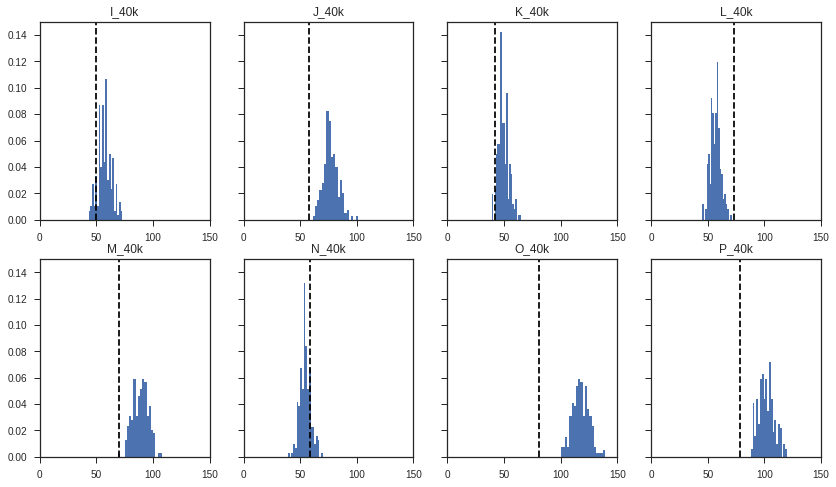

In [148]:
f, axs = plt.subplots(2, 4, sharey=True, figsize=(14, 8))
for ax, stim in zip(axs.flatten(), stim_betticurve_dict.keys()):
    final_bettis = stim_betticurve_dict[stim][-1]
    
    plot_scm_distribution([stim_scm_dict[stim]], 0, 1, ax)
    b = final_bettis[2]
    ax.plot([b, b], [0, 0.15], 'k--')
    ax.set_title(stim)
    ax.set_xlim([0, 150])
    ax.set_ylim([0, 0.15])
    

In [106]:
ax

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcf2d86c50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fbcf36a0dd8>], dtype=object)

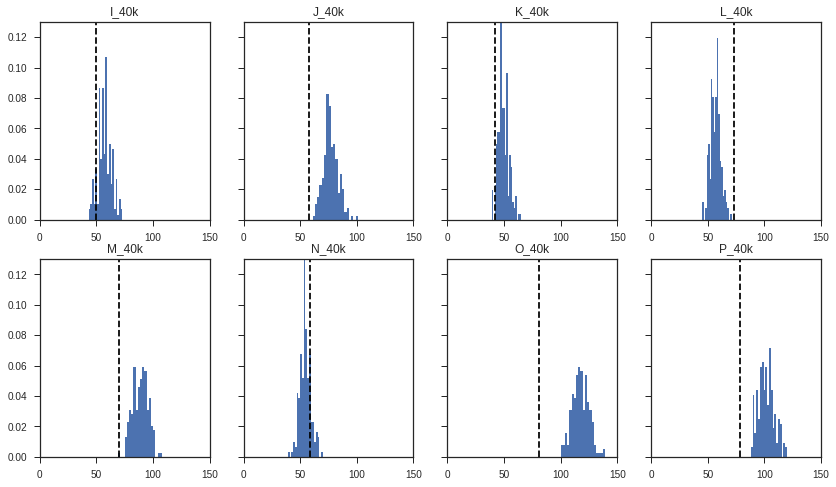

In [153]:
betti=1
f, axs = plt.subplots(2, 4, sharey=True, figsize=(14, 8))
betticols = ['b', 'g', 'r']
for ax, stim in zip(axs.flatten(), stim_betticurve_dict.keys()):
    final_bettis = stim_betticurve_dict[stim][-1]
    
    plot_scm_distribution([stim_scm_dict[stim]], 0, betti, ax)
    b = final_bettis[betti+1]
    ax.plot([b, b], [0, 0.15], 'k--')
    ax.set_title(stim)
    ax.set_xlim([0, 150])
    ax.set_ylim([0, 0.13])
    plt.savefig('/home/brad/krista/B1_FinalBettiVsSCM_TrialAvg_200samps_betti-{}.png'.format(betti))

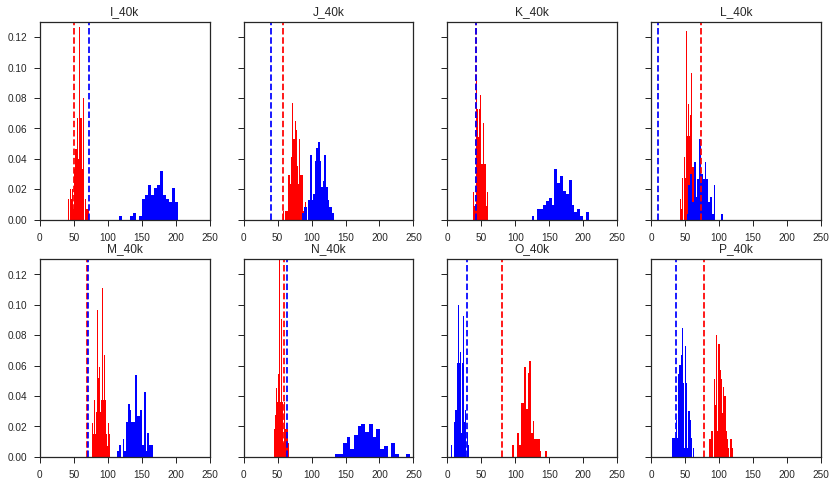

In [131]:
betti=1
f, axs = plt.subplots(2, 4, sharey=True, figsize=(14, 8))
betticols = ['b', 'r', 'b']
bettis = [1,2]
for ax, stim in zip(axs.flatten(), stim_betticurve_dict.keys()):
    final_bettis = stim_betticurve_dict[stim][-1]
    for betti in bettis:
        plot_scm_distribution([stim_scm_dict[stim]], 0, betti, ax, color=betticols[betti])
        b = final_bettis[betti+1]
        ax.plot([b, b], [0, 0.15], betticols[betti]+'--')
    ax.set_title(stim)
    ax.set_xlim([0, 250])
    ax.set_ylim([0, 0.13])
plt.savefig('/home/brad/krista/B1_FinalBettiVsSCM_TrialAvg_allBetti.png')